## 1-1. 문제 소개

**ESO battery Forecasting Heckathon**

- ESO: 영국 전력 시스템의 중심 ⇒ 24시간 내내 가정과 사업체에 필요한 에너지를 공급하기 위해 전력 시스템을 통해 전기를 이동하는 일을 수행
- 전력망에서 배터리의 충전 및 방전 패턴을 예측하고, 이 행동의 주요 요인을 찾는 것이 목표

**배터리의 특징:**

- 태양과 바람 같은 간헐적인 재생 가능 에너지의 초과 에너지를 저장
- 따라서 태양이 없거나 바람이 불지 않을 때 배터리를 활용하여 네트워크의 균형을 유지

## 1-2. 데이터 소개

### **train_data.csv**

- settlement: 정산 기간 → 전력 거래와 균형 조정을 위해 사용되는 30분 단위의 기간.
- battery output: <output: 예측 값> 특정 시간에 배터리를 통해 흐르는 메가와트 양 (+: 배터리가 충전되고 있는 상태, -: 배터리가 방전되고 있는 상태)
- price: 특정 위치에서 전기의 가격
- weather: 특정 위치(10개의 지역)에서 시간별 날씨 조건(temperature, relative humidity, precipitation, rain, snow, cloud cover 등등)
- row: 39457  , column: 294

![스크린샷 2024-07-19 오후 4.05.27.png](attachment:787d0f6f-0d46-4a3f-9e36-dd7d3aca8084.png)

### **test_data.csv**
- 전부 동일하나 battery output 열 존재 X
- battery output을 예측한 csv 파일을 만들어서 제출

![스크린샷 2024-07-19 오후 4.13.15.png](attachment:c599057e-3040-4ac3-a68b-155a50a2eed7.png)

### BOAs.csv

- settlementDate : 전력 거래일
- settlementPeriodFrom, settlementPeroidTo : 결제 시작과 끝 기간
- timeFrom, timeTo : 결제일의 정확한 시간
- levelFrom, levelTo : 전력 level (전력 생산 또는 소비 수준 예상)
- acceptanceNumber, acceptanceTime : 거래 번호와 시간
- deemedBoFlag, soFlag, storFlag, rrFlag : 다양한 상태나 조건을 나타내는 플래그(FALSE 값이라 무효하다고 판단)

![image.png](attachment:image.png)

## 1-3 input, output의 관계

- x(price, 각종 weather 정보들)와 y(battery output)간의 관계를 알아보기 위해 총 10개의 지역간의 평균을 구한 뒤 그래프를 그린 모습


![스크린샷 2024-07-19 오후 4.18.22.png](attachment:c128a275-34c0-456e-8ac5-3507bf429691.png)
![스크린샷 2024-07-19 오후 4.21.02.png](attachment:99962ad3-aa6d-436d-871f-4cd4955fafec.png)
![스크린샷 2024-07-19 오후 4.21.35.png](attachment:a58ac5e0-5502-44b0-8f56-c6471aae72ec.png)
![스크린샷 2024-07-19 오후 4.22.24.png](attachment:bb7b4c4e-f989-4628-9eb0-1d317fac9a56.png)
![스크린샷 2024-07-19 오후 4.23.11.png](attachment:eb5b9faf-742b-4e92-9caa-ed42fd6100c6.png)
![스크린샷 2024-07-19 오후 4.23.47.png](attachment:c70c6084-9856-47f3-acab-c1232fd2bbc7.png)
![스크린샷 2024-07-19 오후 4.24.22.png](attachment:ea2f4240-9240-48da-808e-d38bcb85297e.png)

# 2. 공통 데이터 전처리

**모든 rows의 값이 동일한 Column 이 존재**

![스크린샷 2024-07-19 오후 4.48.12.png](attachment:b087559a-6a93-40fe-9c3c-2883bbe0e58c.png)![스크린샷 2024-07-19 오후 4.49.20.png](attachment:080dd0e3-0a35-4d6a-b566-6f88202fccd8.png)

 **Temperature data는 1시간 단위로 갱신**

![스크린샷 2024-07-19 오후 5.01.39.png](attachment:90ebc70f-c430-4983-a2bd-32ab478fb1eb.png)

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fill_missing_values_vectorized 함수

- 바로 앞,뒤 row의 평균값으로 채움

- 0번째 row는 1번째 row의 값으로 채움

- 마지막 row는 -1번째 row의 값으로 채움

In [ ]:
# 결측값 채우기 함수 (벡터화된 방식)
def fill_missing_values_vectorized(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    columns_to_process = [col for col in numeric_columns if col not in ['id']]

    data = data.copy()  # 원본 데이터 수정 방지

    even_id_indices = data.index[data['id'] % 2 == 0]

    for col in columns_to_process:
        col_data = data[col].values
        for i in even_id_indices:
            if np.isnan(col_data[i]):
                if i == 0:
                    col_data[i] = col_data[i + 1]
                elif i == len(col_data) - 1:
                    col_data[i] = col_data[i - 1]
                else:
                    prev_val = col_data[i - 1]
                    next_val = col_data[i + 1]
                    if not np.isnan(prev_val) and not np.isnan(next_val):
                        col_data[i] = (prev_val + next_val) / 2
                    elif not np.isnan(prev_val):
                        col_data[i] = prev_val
                    elif not np.isnan(next_val):
                        col_data[i] = next_val
        data[col] = col_data

    return data

Data set 불러오기

In [ ]:
# load data
train_set = pd.read_csv("/kaggle/input/eso-data-set/train_data.csv")
test_set = pd.read_csv("/kaggle/input/eso-data-set/test_data.csv")

**모든 rows에 들어있는 값이 동일한 Column을 삭제**

In [ ]:
# column에 모든 value가 같으면 해당 column 제거
train_set = train_set.loc[:, train_set.nunique() != 1] # 90개의 column이 제거됨
test_set = test_set.loc[:, test_set.nunique() != 1] # 90개의 column이 제거됨

**Temperature data 같이 1시간 단위로 갱신되는 데이터의 결측값 채우기**

In [ ]:
# 비어있는 셀에 같은 column 앞,뒤 셀의 평균을 채워넣기
filled_train_set = fill_missing_values_vectorized(train_set)
filled_test_set = fill_missing_values_vectorized(test_set)

# 3. Multi Layer Linear Regression

### 시계열 데이터이지만 , 가장 먼제 Multi Layer Linear Regression 모델로 예측 시도.

- 4개의 Linear Layer 사용

- Batch normalize 사용

- weight initialize 사용

In [ ]:
class BatteryOutputPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(201, 150)
        self.batch_norm1 = nn.BatchNorm1d(150)
        self.linear2 = nn.Linear(150, 100)
        self.batch_norm2 = nn.BatchNorm1d(100)
        self.linear3 = nn.Linear(100, 50)
        self.batch_norm3 = nn.BatchNorm1d(50)
        self.linear4 = nn.Linear(50, 1)

        # Initialize weights using Xavier uniform initialization
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.xavier_uniform_(self.linear4.weight)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)

        x = self.linear4(x)  # No batch norm after the last linear layer
        return x

In [ ]:
model = BatteryOutputPredictionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [ ]:
def train(dataloader,model,optimizer,criterion):

  total_batch = len(dataloader)
  model.train()

  for epoch in range(1000):
    avg_cost = 0

    for X, Y in dataloader:
      X = X.to(device)
      Y = Y.to(device)
      optimizer.zero_grad()
      prediction = model(X)
      loss = criterion(prediction,Y)
      loss.backward()
      optimizer.step()
      avg_cost += loss / total_batch
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

train(dataloader,model,optimizer,criterion)

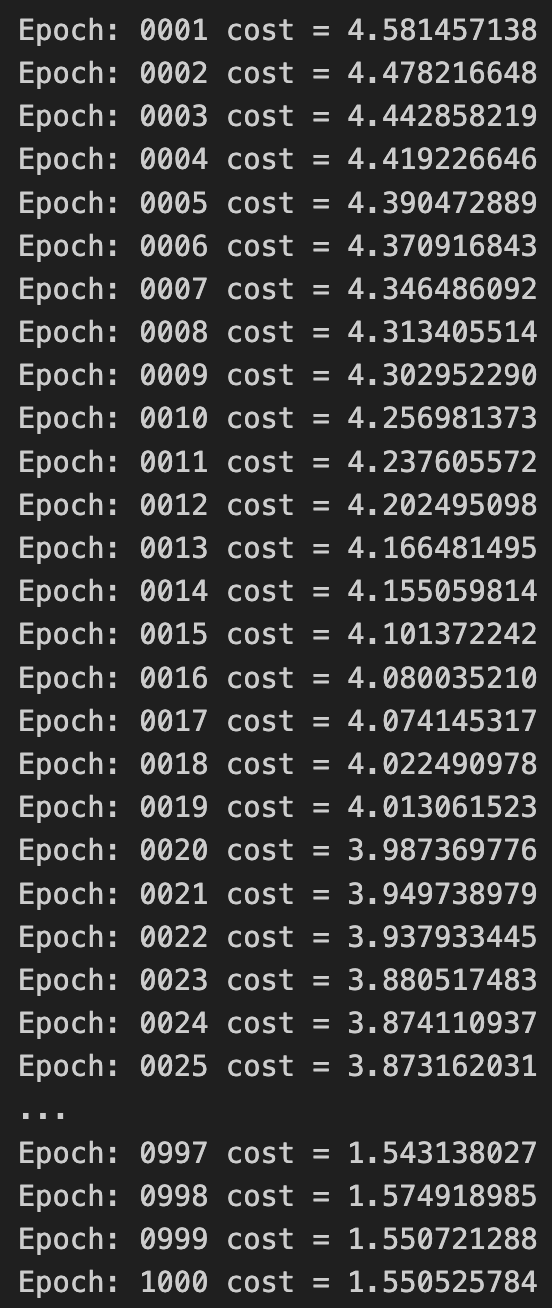

In [ ]:
test_set = pd.read_csv("./data/test_data.csv")
print(test_set.shape)

In [ ]:
def evaluate_and_save(dataloader, model, file_path):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []

    with torch.no_grad():  # 기울기 계산 비활성화
        for X, in dataloader:  # 데이터 로더에서 데이터 배치를 반복
            X = X.to(device)  # 데이터를 적절한 디바이스로 이동 (CPU 또는 GPU)
            output = model(X)  # 모델로부터 예측 수행
            predictions.extend(output.cpu().numpy())  # 예측값을 리스트에 저장

    # 예측 결과를 DataFrame으로 변환
    predicted_df = pd.DataFrame(predictions, columns=['battery_output'])
    # "id" 컬럼 추가
    predicted_df["id"] = range(39457, 39457 + len(predicted_df))
    # "id" 컬럼을 첫 번째 컬럼으로 이동
    predicted_df = predicted_df[["id", "battery_output"]]
    print(predicted_df.shape)

    # 결과를 CSV 파일로 저장
    predicted_df.to_csv(file_path, index=False)


In [ ]:
file_path = "./submission/Linear_Prediction.csv"
evaluate_and_save(dataloader, model, file_path)

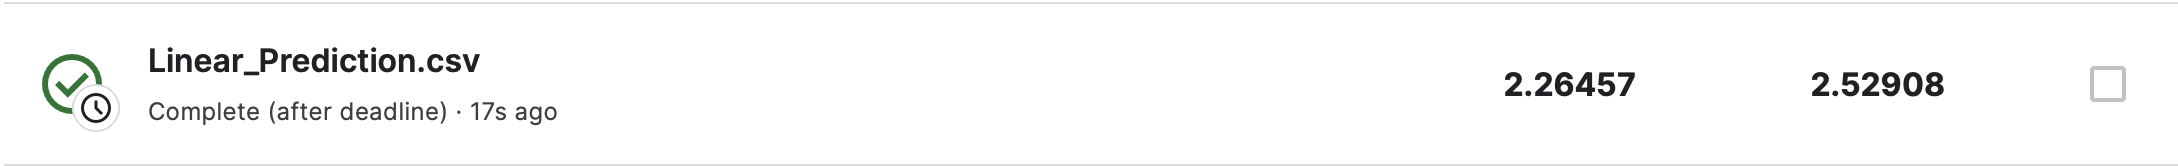

# 4. Feature Engineering (random forest)

### 4-1. 데이터 전처리

- id와 battery_output을 제외한 data를 x_data에 넣고, battery_output을 y_data에 넣음

- MinMaxScaler()을 이용하여 데이터스케일링(정규화)을 진행

- 시계열데이터의 원활한 처리를 위하여 TimeSeriesSplit을 사용함

In [ ]:
# 시계열 인덱스 설정
filled_trained_set_subset['UTC_Settlement_DateTime'] = pd.to_datetime(filled_trained_set_subset['UTC_Settlement_DateTime'])
filled_trained_set_subset.set_index('UTC_Settlement_DateTime', inplace=True)

# 시간 관련 피처 추가
filled_trained_set_subset['year'] = filled_trained_set_subset.index.year
filled_trained_set_subset['month'] = filled_trained_set_subset.index.month
filled_trained_set_subset['day'] = filled_trained_set_subset.index.day
filled_trained_set_subset['hour'] = filled_trained_set_subset.index.hour

# 데이터셋 분할 및 정규화
data = filled_trained_set_subset
target_variable = 'battery_output'
x_data = data.drop(columns=[target_variable, 'id'])
y_data = data[target_variable]
numeric_columns = x_data.select_dtypes(include=[np.number]).columns

# x_data 정규화
x_scaler = MinMaxScaler()
x_data[numeric_columns] = x_scaler.fit_transform(x_data[numeric_columns])
x_data.fillna(0, inplace=True)

# y_data 정규화
y_scaler = MinMaxScaler()
y_data = y_scaler.fit_transform(y_data.values.reshape(-1, 1)).flatten()

# TimeSeriesSplit 사용
tscv = TimeSeriesSplit(n_splits=10)
mse_scores = []

### 4-2. Random Forest 모델 학습, 예측 (Score: 1.97482)

⇒ Random Forest는 다양한 피처를 고려하고, 과적합을 방지하며, 예측 성능을 향상시키는 데 효과적인 모델. 데이터 전처리, 피처 선택, 정규화, 교차 검증과 같은 과정은 모델 성능을 최적화하는 데 중요한 역할을 하였고, 이 모델은 특히 결측값이 있는 시계열 데이터나 다양한 피처를 가진 데이터셋에서 유용하기 때문에 사용함

하이퍼파라미터튜닝을 계속 진행하면서 성능을 높임

In [ ]:
for train_index, test_index in tscv.split(x_data):
    x_train, x_test = x_data.iloc[train_index], x_data.iloc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # Random Forest 모델 학습
    #rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model = RandomForestRegressor(
        n_estimators=150,  # 트리 수
        max_depth=6,  # 트리 최대 깊이 조정
        min_samples_split=10,  # 노드를 분할하기 위한 최소 샘플 수 증가
        min_samples_leaf=10,  # 리프 노드에 있어야 하는 최소 샘플 수 증가
        max_features='sqrt',  # 각 분할에서 고려할 최대 피처 수
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(x_train, y_train)

    # 피처 중요도 계산
    feature_importances = rf_model.feature_importances_
    features = x_train.columns

    # 중요한 피처 선택
    important_features = features[np.argsort(feature_importances)[-140:]]
    x_train_important = x_train[important_features]
    x_test_important = x_test[important_features]

    # 재학습
    rf_model.fit(x_train_important, y_train)

    # 예측
    y_train_pred = rf_model.predict(x_train_important)
    y_test_pred = rf_model.predict(x_test_important)

    # 성능 평가
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f'Train MSE: {train_mse:.4f}')
    print(f'Test MSE: {test_mse:.4f}')

    mse_scores.append(test_mse)

### 4-3. Score

![KakaoTalk_Photo_2024-07-20-01-17-45.png](attachment:KakaoTalk_Photo_2024-07-20-01-17-45.png)

# 5. Feature Engineering (XGBoost)

### 5-1. 데이터 전처리

- time series data 이기 때문에 Datetime data을 모델 학습에 활용

    - 년, 월, 일 , 시, 분

    - 요일
    
    - 주말인지, 주중인지

In [ ]:
# 날짜 및 시간 데이터를 datetime 형식으로 변환
data['UTC_Settlement_DateTime'] = pd.to_datetime(data['UTC_Settlement_DateTime'])

# 시간 특성 추출
data['year'] = data['UTC_Settlement_DateTime'].dt.year
data['month'] = data['UTC_Settlement_DateTime'].dt.month
data['day'] = data['UTC_Settlement_DateTime'].dt.day
data['hour'] = data['UTC_Settlement_DateTime'].dt.hour
data['minute'] = data['UTC_Settlement_DateTime'].dt.minute

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# 요일별 특성 추가
data['day_of_week'] = data['UTC_Settlement_DateTime'].dt.dayofweek  # 월요일(0)부터 일요일(6)까지
data['weekday'] = data['UTC_Settlement_DateTime'].dt.weekday  # 월요일(0)부터 일요일(6)까지
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(int)  # 주말 여부 추가 (주말이면 1, 주중이면 0)

- 계절

    - string 타입 → one hot encoding

- peak 시간대 training

    - 1am~24pm

In [ ]:
# 계절성 변수 추가 (예시)
def get_season(month):
    if month in [3, 4, 5]:   # 봄
        return 'spring'
    elif month in [6, 7, 8]: # 여름
        return 'summer'
    elif month in [9, 10, 11]: # 가을
        return 'autumn'
    else:                    # 겨울
        return 'winter'

data['season'] = data['UTC_Settlement_DateTime'].dt.month.apply(get_season)

from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding을 위해 범주형 변수로 변환
season_encoder = OneHotEncoder()
season_encoded = season_encoder.fit_transform(data[['season']])

# 변환add된 데이터를 DataFrame으로 변환 후 기존 데이터와 합치기
season_encoded_df = pd.DataFrame(season_encoded.toarray(), columns=season_encoder.categories_[0])
data = pd.concat([data, season_encoded_df], axis=1)
# 변환된 데이터에서 season 열 삭제
data = data.drop(['season'], axis=1)

# 1am-12pm 시간대 필터링
peak_hours_data = data[(data['hour'] >= 1) & (data['hour'] <= 24)]

- 다른 시도1. 30분마다 data들의 location마다의 날씨의 평균을 저장하여 그 정보로  training
- 각 location의 날씨 평균을 30분 단위로 저장한 data로 모델을 학습

    - 결과가 별로 좋지 않았음.
    
    - row개수가 3만개 이상으로 너무 많아 시간이 너무 오래걸림.

In [ ]:
# 'Location'이 맨 앞 글자에 있는 열 이름들 찾기
location_columns = ['Glasgow', 'Leeds', 'Manchester', 'Sheffield']

# 각 지역별 열 이름을 설정
columns = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
           'precipitation', 'rain', 'snowfall', 'weathercode', 'surface_pressure',
           'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
           'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m',
           'windgusts_10m', 'is_day']

# 각 열에 대해 평균을 계산하는 함수
def calculate_average(df, location_columns, columns):
    avg_df = pd.DataFrame()
    for col in columns:
        cols = [f'{col}_{location}_weather' for location in location_columns]
        avg_df[col] = df[cols].mean(axis=1)
    return avg_df

# 평균값을 저장할 데이터프레임 초기화
avg_data = pd.DataFrame()

# 각 시간별로 평균을 계산
for time, group in data.groupby(data['UTC_Settlement_DateTime']):
    avg_row = calculate_average(group, location_columns, columns)
    avg_row['UTC_Settlement_DateTime'] = time
    avg_data = pd.concat([avg_data, avg_row], ignore_index=True)


- 다른 시도2. BOAs.csv 정보 활용

  - 해당 시간대의 전력 level에 대한 정보를 알 수 있으므로 사용해보았으나 오히려 score가 증가

In [ ]:
# 예측값을 저장할 열 추가
test_data['predicted_level_change'] = None

# 각 test_data 행에 대해 조건에 맞는 boas_data_subset 행 찾기
for idx, row in test_data.iterrows():
    condition = (
        (boas_data_subset['year'] == row['year']) &
        (boas_data_subset['month'] == row['month']) &
        (boas_data_subset['day'] == row['day']) &
        (boas_data_subset['hour'] == row['hour']) &
        (boas_data_subset['minute'] > row['minute'])
    )
    matching_rows = boas_data_subset[condition]

    if not matching_rows.empty:
        closest_match = matching_rows.iloc[0]
        level_change = closest_match['levelFrom'] - closest_match['levelTo']
        test_data.at[idx, 'predicted_level_change'] = level_change

# 결측치 처리: NaN 값을 0으로 대체
test_data['predicted_level_change'].fillna(0, inplace=True)


# Convert test_pred to a DataFrame for easier manipulation
test_pred_df = pd.DataFrame(test_pred, columns=['predicted'])

# Verify test_data has the column
if 'predicted_level_change' not in test_data.columns:
    raise KeyError("Column 'predicted_level_change' not found in test_data.")

# Replace predictions where predicted_level_change is not 0
test_pred_df['predicted'] = np.where(test_data['predicted_level_change'] != 0,
                                      test_data['predicted_level_change'],
                                      test_pred_df['predicted'])

# If you need the final predictions in a numpy array
test_pred = test_pred_df['predicted'].values

### 5-2. XGBoost 모델 학습, 예측 (Score: 1.97230)

Features 선정

- Glasgow의 wind 정보를 활용

In [ ]:
# 특성 및 레이블 선택
features = peak_hours_data[['year', 'month', 'day', 'hour', 'minute',
                            'hour_sin', 'hour_cos', 'day_of_week', 'is_weekend', 'autumn', 'spring', 'summer','winter',
                            'windspeed_10mGlasgow_weather',
                            'winddirection_10mGlasgow_weather',
                            'windgusts_10mGlasgow_weather',
                            ]]
labels = peak_hours_data['battery_output']

SHAP을 활용하여 가장 영향을 많이 미치는 10개의 features만 선정하여 training

In [ ]:
# XGBoost 모델을 사용하여 SHAP 값을 계산
model_initial = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_initial.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.Explainer(model_initial, X_train)
shap_values = explainer(X_train)

# SHAP 값의 평균 절대값 계산
shap_importance = np.abs(shap_values.values).mean(axis=0)

# 중요도에 따라 피처 이름을 정렬
feature_importance = pd.Series(shap_importance, index=X_train.columns)
top_features = feature_importance.nlargest(10)  # 상위 10개 피처 선택

# 상위 피처들만 선택
top_feature_names = top_features.index
X_train_reduced = X_train[top_feature_names]
X_valid_reduced = X_valid[top_feature_names]

In [ ]:
# XGBoost 모델 초기화 및 하이퍼파라미터 설정
model = XGBRegressor(
    n_estimators=30,  # 트리의 개수
    learning_rate=0.01,  # 학습률
    max_depth=5,  # 트리의 최대 깊이
    subsample=0.8,  # 각 트리를 훈련할 때 사용할 훈련 데이터의 비율
    colsample_bytree=0.8,  # 각 트리를 훈련할 때 사용할 특성의 비율
    random_state=42  # 재현성을 위한 랜덤 시드
)

model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)


optuna를 활용하여 hyperparameter tuning을 하여 training

In [ ]:
# Optuna objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 공간 정의
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-3, 10.0)
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_valid_reduced)
    mse = mean_squared_error(y_valid, y_pred)

    return mse

# Optuna Study 객체 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터
best_params = study.best_params
print('Best hyperparameters:', best_params)
print('Best score (MSE):', study.best_value)

# 최적의 하이퍼파라미터로 모델 재훈련
model_final = xgb.XGBRegressor(**best_params, random_state=42)
model_final.fit(X_train_reduced, y_train)

# 테스트 데이터에 대한 예측
y_pred_final = model_final.predict(X_valid_reduced)

Hyperparameter tuning

- 수동으로 설정 (n_estimator = 30, max_depth = 5, random_state=42 로 했을 때 가장 좋았음)
    - n_estimator = 300 으로 변경해보라는 피드백을 받아서 변경 (그러나 성능 향상 X)

### 5-3. Score

![KakaoTalk_Photo_2024-07-20-01-16-02.png](attachment:KakaoTalk_Photo_2024-07-20-01-16-02.png)

# 6. LSTM

### 6-1. LSTM 데이터 전처리

하이퍼파라미터 설정

In [ ]:
# hyper parameters

seq_length = 10
data_dim = 200 # Exclude label
hidden_dim = 30
output_dim = 1
learning_rate = 0.015
iterations = 20

데이터 전처리에 사용되는 함수 정의

- minmax_scaler: 데이터의 최대값과 최소값을 1과 0으로 두고 정규화하는 함수

- inverse_minmax_scaler: 정규화된 값을 원본 데이터의 단위로 되돌리는 함수

- build_dataset: LSTM 모델 학습을 위해 데이터를 seq_length 단위로 나누는 함수

- build_dataset_test: X 데이터만 seq_length 단위로 나누는 함수

In [ ]:
# np.min(data, 0)  ->  열(column)별 최소값
# np.max(data, 0)  ->  열(column)별 최대값
# scaling function for input data
def minmax_scaler(data):
    # numerator: 원본 데이터 - 최소값 = 데이터를 0 기준으로 이동
    numerator = data - np.min(data, axis=0)
    # denominator: 최대값과 최소값의 차: 데이터의 범위
    denominator = np.max(data, axis=0) - np.min(data, axis=0)

    # 데이터의 값을 0과 1 사이로 스케일링
    # 1e-7: ZeroDivisionError 방지
    return numerator / (denominator + 1e-7), np.min(data, axis=0), np.max(data, axis=0)

# inverse scaling function
def inverse_minmax_scaler(data, min_val, max_val):
    return data * (max_val - min_val + 1e-7) + min_val

# make dataset to input
# 시계열 데이터를 입력으로 받아 학습에 사용할 데이터셋을 생성
def build_dataset(time_series, seq_length):

    dataX = []
    dataY = []

    # 반복문 0~(데이터 길이 - 시퀀스 길이)
    for i in range(0, len(time_series) - seq_length):

        # row: i부터 시퀀스 길이(i+시퀀스 길이 직전) | column: 전부(label 행 포함)
        #_x = time_series[i:i + seq_length, :] # Include the close price column
        _x = time_series[i:i + seq_length, :-1] # Exclude the close price column

        # row: i+시퀀스 길이 열(1개 열) | column: 마지막 행 (label, 종가)
        _y = time_series[i + seq_length, [-1]]  # Next close price

        # print(_x, "->", _y) # 시각화

        dataX.append(_x) # input data set에 추가
        dataY.append(_y) # label set에 추가

    # numpy 배열로 리턴
    return np.array(dataX), np.array(dataY)

# make dataset to input
# 시계열 데이터를 입력으로 받아 학습에 사용할 데이터셋을 생성
def build_dataset_test(time_series, seq_length):

    dataX = []

    # 반복문 0~(데이터 길이 - 시퀀스 길이)
    for i in range(0, len(time_series) - seq_length):

        # row: i부터 시퀀스 길이(i+시퀀스 길이 직전) | column: 전부(label 행 포함)
        #_x = time_series[i:i + seq_length, :] # Include the close price column
        _x = time_series[i:i + seq_length, :] # Exclude the close price column

        # print(_x, "->  ?") # 시각화

        dataX.append(_x) # input data set에 추가

    # numpy 배열로 리턴
    return np.array(dataX)

id와 time 정보를 담고있는 column 제거

In [ ]:
# id, time column drop
PP_train_data = filled_train_set.iloc[:,2:]
PP_test_data = filled_test_set.iloc[:,2:]

train_data의 첫 번째 열(battery_output)을 마지막(y_data 위치)으로 이동

In [ ]:
cols = PP_train_data.columns.tolist()
cols.append(cols.pop(0))
PP_train_data = PP_train_data[cols]

In [ ]:
# J번째 column 버리기 (값이 유실된 cell 다수)
PP_train_data = PP_train_data.drop(PP_train_data.columns[9], axis=1)
PP_test_data = PP_test_data.drop(PP_test_data.columns[9], axis=1)

# 아직도 빈 곳을 column의 평균으로 채우기
PP_train_data = PP_train_data.apply(lambda col: col.fillna(col.mean()), axis=0)
PP_test_data = PP_test_data.apply(lambda col: col.fillna(col.mean()), axis=0)

# column name 담긴 row 앞에 '#' 추가
PP_train_data = PP_train_data.rename(columns={'East_Midlands_price': '#East_Midlands_price'})
PP_test_data = PP_test_data.rename(columns={'East_Midlands_price': '#East_Midlands_price'})

print(PP_train_data.shape)
print(PP_test_data.shape)

LSTM 모델을 사용하므로 train_data의 마지막 행에서
Sequence Length 만큼의 데이터를 복사하여 test_data의 0번째 행 앞에 추가

In [ ]:
# LSTM의 seq_length 만큼 train_data의 마지막 행들을 복사.
last_rows = PP_train_data.iloc[-seq_length:].copy()

# 마지막 Label 열을 제거.
last_rows_trimmed = last_rows.iloc[:, :-1]

# test_data의 0번째 행 앞에 last_rows를 추가.
PP_test_data = pd.concat([last_rows_trimmed, PP_test_data], ignore_index=True)

print(PP_test_data.shape)

전처리 된 data 확인 위해 추출, numpy loadtxt 함수로 다시 로드

In [ ]:
# 전처리 된 data set 추출
# PP_train_data.to_csv('/kaggle/input/pp-data/PP_train_data.csv', index=False)
# PP_test_data.to_csv('/kaggle/input/pp-data/PP_test_data.csv', index=False)

In [ ]:
# load data
train_set = np.loadtxt("/kaggle/input/pp-data/PP_train_data.csv", delimiter=",")
test_set = np.loadtxt("/kaggle/input/pp-data/PP_test_data.csv", delimiter=",")

LSTM 모델 학습을 위해 데이터를 seq_length 단위로 나누기

In [ ]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
print(trainX.shape)
print(trainY.shape)

testX = build_dataset_test(test_set, seq_length)
print(testX.shape)

minmax_scaler를 사용해서 data 정규화

In [ ]:
# scaling data (정규화)
trainX, _, _ = minmax_scaler(trainX)
trainY, trainY_min, trainY_max = minmax_scaler(trainY)

testX, _, _ = minmax_scaler(testX)

데이터를 FloatTensor 타입으로 변환

In [ ]:
# device = 'cpu'
device = 'mps'


# convert to tensor
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
print(trainX_tensor.shape)
print(trainY_tensor.shape)

testX_tensor = torch.FloatTensor(testX).to(device)
print(testX_tensor.shape)

배치 단위로 train data 준비

In [ ]:
train_dataset = torch.utils.data.TensorDataset(trainX_tensor, trainY_tensor)

batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)


### 6-2. LSTM 모델 학습, 예측 (Score: 1.97089)

LSTM 모델 정의 및 생성

- LSTM Layer 1개

- Fully Connected Layer 1개


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        # LSTM 사용
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1).to(device)

- MSE로 손실 계산

- Adam Optimizer 사용

In [ ]:
# loss & optimizer setting
criterion = torch.nn.MSELoss() # MSE 사용
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Training

In [ ]:
# start training
for i in range(iterations):
    for batch_idx, (batch_X, batch_Y) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    print(i+1, loss.item())

Prediction, 역정규화

In [ ]:
# Predict on test data
net.eval()

with torch.no_grad():
    predicted = net(testX_tensor).detach().cpu().numpy()

# 예측값, 레이블 역정규화 (Kaggle 채점을 위해)
predicted = inverse_minmax_scaler(predicted, trainY_min, trainY_max)
print(predicted.shape)

예측결과를 Pandas DataFrame으로 변환

소수점 4번째 자리에서 반올림

In [ ]:
predicted_df = pd.DataFrame(predicted, columns=["battery_output"])
predicted_df = predicted_df.round(3)
print(predicted_df.head())

Kaggle 제출 형식에 맞춰서 id column 추가

In [ ]:
# "id" 컬럼 추가
predicted_df["id"] = range(39457, 39457 + len(predicted_df))
# "id" 컬럼을 첫 번째 컬럼으로 이동
predicted_df = predicted_df[["id", "battery_output"]]
print(predicted_df.shape)
print(predicted_df.head())

CSV 파일로 추출

In [ ]:
# DataFrame을 CSV 파일로 저장
csv_file_path = "/kaggle/working/Prediction.csv"
predicted_df.to_csv(csv_file_path, index=False)

### 6-3. Score

LSTM이 가장 높은 성능을 보였다

- Kaggle Leaderboard의 37개의 제출물 중에서 8번째에 해당하는 Score


![스크린샷 2024-07-19 오후 5.06.22.png](attachment:69ab2cd4-0497-4f58-9de1-c191f71ab0b1.png)